In [1]:
import os
import nltk
from nltk.util import ngrams
import pickle
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from scipy.stats import ttest_rel

from tools.corpus_reader import CHILDESCorpusReader
from tools.functions import nansem, turns, turn_pairs
from tools.measures import dlg_mul, dlg_mwl, shared_ngrams, diff_matrix, \
conv_matrix, global_rate, local_rate

np.random.seed(42)

# read Brown corpus
nltk.data.path.append(os.getcwd() + '/data/nltk_data/')
corpus_root = nltk.data.find('corpora/childes/data-xml/Eng-USA')
brown = CHILDESCorpusReader(corpus_root, 'Brown/.*.xml')

# dialogue files for Adam and Sarah
adam_dlgs = [fileID for fileID in brown.fileids() if 'Adam' in fileID]
sarah_dlgs = [fileID for fileID in brown.fileids() if 'Sarah' in fileID]

## Extract turn pairs for all dialogues

In [2]:
# # load files for Adam or Sarah
# name = 'sarah'
# dlg_files = sarah_dlgs

# ages = []
# sent_turn_pairs = {}
# postag_turn_pairs = {}

# # extract turn pairs (for words and POS tags) and pickle to file
# for dlg_file in dlg_files:
#     dlg_sents = brown.sents(dlg_file)
#     tagged_sents = brown.tagged_sents(dlg_file)
#     dlg_postags = [[spkID, [w[1] for w in utt]]
#               for spkID, utt in tagged_sents]
    
#     age = round(float(brown.age(dlg_file, month=True)[0]), 2)
#     if age in ages:
#         age += 0.01
#     ages.append(age)
#     print(age)
    
#     sent_turnp = turn_pairs(turns(dlg_sents))
#     sent_turn_pairs[age] = sent_turnp
    
#     postag_turnp = turn_pairs(turns(dlg_postags))
#     postag_turn_pairs[age] = postag_turnp
    
#     pickle.dump(sent_turn_pairs, open(name + '_sent_turn-pairs.pkl', 'wb'))
#     pickle.dump(postag_turn_pairs, open(name + '_pos_turn-pairs.pkl', 'wb'))

In [3]:
# load from pickles
adam_sent_turn_pairs = pickle.load(open('data/pickles/adam_sent_turn-pairs.pkl', 'rb'))
adam_pos_turn_pairs = pickle.load(open('data/pickles/adam_pos_turn-pairs.pkl', 'rb'))
sarah_sent_turn_pairs = pickle.load(open('data/pickles/sarah_sent_turn-pairs.pkl', 'rb'))
sarah_pos_turn_pairs = pickle.load(open('data/pickles/sarah_pos_turn-pairs.pkl', 'rb'))

sarah_ages = list(sorted(sarah_sent_turn_pairs.keys()))
adam_ages = list(sorted(adam_sent_turn_pairs.keys()))

### Exclude turns
Exclude any turn pairs that have a turn with mean utterance length < 2.

In [4]:
def idx_to_exclude(turn_pairs):
    """
    Returns indices of turn pairs to exclude
    (those that contain a turn for which the MUL is
    lower than 2)
    """
    exclude = []
    for idx, (turn_i, turn_j) in enumerate(turn_pairs):
        mul_i = np.mean([len(u) for u in turn_i[1]])
        mul_j = np.mean([len(u) for u in turn_j[1]])
        if mul_i < 2 or mul_j < 2:
            exclude.append(idx)
    return exclude

excl_pct = []
for age in adam_sent_turn_pairs.keys():
    adam_excl_idx = idx_to_exclude(adam_sent_turn_pairs[age])
    
    pct = round((len(adam_excl_idx)/len(adam_sent_turn_pairs[age]))*100,1)
    excl_pct.append(pct)
    # print percentage of each dialogue excluded
    # print(pct, '%')
    adam_sent_turn_pairs[age] = [t for i, t in enumerate(adam_sent_turn_pairs[age])
                                if i not in adam_excl_idx]
    adam_pos_turn_pairs[age] = [t for i, t in enumerate(adam_pos_turn_pairs[age])
                               if i not in adam_excl_idx]
print(np.mean(excl_pct), '% of Adam corpus excluded')

excl_pct = []
for age in sarah_sent_turn_pairs.keys():
    sarah_excl_idx = idx_to_exclude(sarah_sent_turn_pairs[age])
    
    pct = round((len(sarah_excl_idx)/len(sarah_sent_turn_pairs[age]))*100,1)
    excl_pct.append(pct)
    # print percentage of each dialogue excluded
    # print(pct, '%')
    sarah_sent_turn_pairs[age] = [t for i, t in enumerate(sarah_sent_turn_pairs[age])
                                if i not in sarah_excl_idx]
    sarah_pos_turn_pairs[age] = [t for i, t in enumerate(sarah_pos_turn_pairs[age])
                               if i not in sarah_excl_idx]
print(np.mean(excl_pct), '% of Sarah corpus excluded')

28.067272727272734 % of Adam corpus excluded
49.63381294964029 % of Sarah corpus excluded


## Compute measures and matrices

In [5]:
# name = 'sarah'
# dlg_files = sarah_dlgs
# sent_turn_pairs = sarah_sent_turn_pairs
# postag_turn_pairs = sarah_pos_turn_pairs
# excl_idx = sarah_excl_idx

# d_range = range(11)

# measures = {'ages': [],
#             'MWL': {'CHI': [], 'ADT': [], 
#                     'matrix': {}, 'shuffled': {},
#                     'GlobRR': [], 'RR2pos': [], 'RR2neg': [],
#                     'LocRR': {d: [] for d in d_range},
#                     'shLocRR': {d: [] for d in d_range}},
#             'MUL': {'CHI': [], 'ADT': [], 
#                     'matrix': {}, 'shuffled': {},
#                     'GlobRR': [], 'RR2pos': [], 'RR2neg': [],
#                     'LocRR': {d: [] for d in d_range},
#                     'shLocRR': {d: [] for d in d_range}},
#             'LexUni': {'matrix': {}, 'shuffled': {},
#                        'GlobRR': [], 'RR2pos': [], 'RR2neg': [],
#                        'LocRR': {d: [] for d in d_range},
#                        'shLocRR': {d: [] for d in d_range}},
#             'LexBi': {'matrix': {}, 'shuffled': {},
#                       'GlobRR': [], 'RR2pos': [], 'RR2neg': [],
#                       'LocRR': {d: [] for d in d_range},
#                       'shLocRR': {d: [] for d in d_range}},
#             'PosBi': {'matrix': {}, 'shuffled': {},
#                       'GlobRR': [], 'RR2pos': [], 'RR2neg': [],
#                       'LocRR': {d: [] for d in d_range},
#                       'shLocRR': {d: [] for d in d_range}}}

# for dlg_file in dlg_files:
    
#     # get dialogue sentences and POS tags
#     dlg_sents = brown.sents(dlg_file)
#     tagged_sents = brown.tagged_sents(dlg_file)
#     dlg_postags = [[spkID, [w[1] for w in utt]]
#               for spkID, utt in tagged_sents]
    
#     # child's age
#     age = round(float(brown.age(dlg_file, month=True)[0]), 2)
#     if age in measures['ages']:
#         age += 0.01
#     measures['ages'].append(age)
#     print(age)
    
#     # compute child's and adults' mean word lengths
#     dlg_mwordlen = dlg_mwl(dlg_sents)
#     chi_mwordlen = [utt[1] for utt in dlg_mwordlen 
#                     if utt[0] == 'CHI']
#     adt_mwordlen = [utt[1] for utt in dlg_mwordlen 
#                     if utt[0] != 'CHI']
#     measures['MWL']['CHI'].append((np.nanmean(chi_mwordlen), nansem(chi_mwordlen)))
#     measures['MWL']['ADT'].append((np.nanmean(adt_mwordlen), nansem(adt_mwordlen)))
    
#     # compute child's and adults' mean utterance lengths
#     dlg_muttlen = dlg_mul(dlg_sents)
#     chi_muttlen = [utt[1] for utt in dlg_muttlen 
#                     if utt[0] == 'CHI']
#     adt_muttlen = [utt[1] for utt in dlg_muttlen 
#                     if utt[0] != 'CHI']
#     measures['MUL']['CHI'].append((np.nanmean(chi_muttlen), nansem(chi_muttlen)))
#     measures['MUL']['ADT'].append((np.nanmean(adt_muttlen), nansem(adt_muttlen)))    
    
#     # matrices and shuffled matrices for MWL and MUL
#     mwl_tp = [t for i, t in enumerate(turn_pairs(dlg_mwl(dlg_sents)))
#               if i not in excl_idx]
#     mwl_rec_mat = diff_matrix(mwl_tp)
#     shf_mwl_mat = np.copy(mwl_rec_mat.flat)
#     np.random.shuffle(shf_mwl_mat)
#     shf_mwl_mat = shf_mwl_mat.reshape(mwl_rec_mat.shape)
#     measures['MWL']['matrix'][age] = mwl_rec_mat
#     measures['MWL']['shuffled'][age] = shf_mwl_mat
    
#     mul_tp = [t for i, t in enumerate(turn_pairs(dlg_mul(dlg_sents)))
#              if i not in excl_idx]
#     mul_rec_mat = diff_matrix(mul_tp)
#     shf_mul_mat = np.copy(mul_rec_mat.flat)
#     np.random.shuffle(shf_mul_mat)
#     shf_mul_mat = shf_mul_mat.reshape(mul_rec_mat.shape)
#     measures['MUL']['matrix'][age] = mul_rec_mat
#     measures['MUL']['shuffled'][age] = shf_mwl_mat
    
#     # matrices and shuffled matrices for lexical unigrams and bigrams
#     lexuni_rec_mat = conv_matrix(sent_turn_pairs[age], n=1)
#     shf_lexuni_mat = np.copy(lexuni_rec_mat.flat)
#     np.random.shuffle(shf_lexuni_mat)
#     shf_lexuni_mat = shf_lexuni_mat.reshape(lexuni_rec_mat.shape)
#     measures['LexUni']['matrix'][age] = lexuni_rec_mat
#     measures['LexUni']['shuffled'][age] = shf_lexuni_mat
    
#     lexbi_rec_mat = conv_matrix(sent_turn_pairs[age], n=2)
#     shf_lexbi_mat = np.copy(lexbi_rec_mat.flat)
#     np.random.shuffle(shf_lexbi_mat)
#     shf_lexbi_mat = shf_lexbi_mat.reshape(lexbi_rec_mat.shape)
#     measures['LexBi']['matrix'][age] = lexbi_rec_mat
#     measures['LexBi']['shuffled'][age] = shf_lexbi_mat
    
#     # matrix and shuffled matrix for pos bigrams
#     posbi_rec_mat = conv_matrix(postag_turn_pairs[age], n=2)
#     shf_posbi_mat = np.copy(posbi_rec_mat.flat)
#     np.random.shuffle(shf_posbi_mat)
#     shf_posbi_mat = shf_posbi_mat.reshape(posbi_rec_mat.shape)
#     measures['PosBi']['matrix'][age] = posbi_rec_mat
#     measures['PosBi']['shuffled'][age] = shf_posbi_mat
    
#     # global recurrence rates
#     measures['MWL']['GlobRR'].append(global_rate(mwl_rec_mat))
#     measures['MUL']['GlobRR'].append(global_rate(mul_rec_mat))
#     measures['LexUni']['GlobRR'].append(global_rate(lexuni_rec_mat))
#     measures['LexBi']['GlobRR'].append(global_rate(lexbi_rec_mat))
#     measures['PosBi']['GlobRR'].append(global_rate(posbi_rec_mat))
    
#     # positive and negative local recurrence rates (d = 2)
#     measures['MWL']['RR2pos'].append(local_rate(mwl_rec_mat, d=2, subset='pos'))
#     measures['MWL']['RR2neg'].append(local_rate(mwl_rec_mat, d=2, subset='neg'))
#     measures['MUL']['RR2pos'].append(local_rate(mul_rec_mat, d=2, subset='pos'))
#     measures['MUL']['RR2neg'].append(local_rate(mul_rec_mat, d=2, subset='neg'))
#     measures['LexUni']['RR2pos'].append(local_rate(lexuni_rec_mat, d=2, subset='pos'))
#     measures['LexUni']['RR2neg'].append(local_rate(lexuni_rec_mat, d=2, subset='neg'))
#     measures['LexBi']['RR2pos'].append(local_rate(lexbi_rec_mat, d=2, subset='pos'))
#     measures['LexBi']['RR2neg'].append(local_rate(lexbi_rec_mat, d=2, subset='neg'))
#     measures['PosBi']['RR2pos'].append(local_rate(posbi_rec_mat, d=2, subset='pos'))
#     measures['PosBi']['RR2neg'].append(local_rate(posbi_rec_mat, d=2, subset='neg'))
    
#     # local recurrence rates for d between 0 and 10,
#     # for shuffled and unshuffled matrices
#     for d in d_range:
#         measures['MWL']['LocRR'][d].append(local_rate(mwl_rec_mat, d=d))
#         measures['MWL']['shLocRR'][d].append(local_rate(shf_mwl_mat, d=d))
#         measures['MUL']['LocRR'][d].append(local_rate(mul_rec_mat, d=d))
#         measures['MUL']['shLocRR'][d].append(local_rate(shf_mul_mat, d=d))
#         measures['LexUni']['LocRR'][d].append(local_rate(lexuni_rec_mat, d=d))
#         measures['LexUni']['shLocRR'][d].append(local_rate(shf_lexuni_mat, d=d))
#         measures['LexBi']['LocRR'][d].append(local_rate(lexbi_rec_mat, d=d))
#         measures['LexBi']['shLocRR'][d].append(local_rate(shf_lexbi_mat, d=d))
#         measures['PosBi']['LocRR'][d].append(local_rate(posbi_rec_mat, d=d))
#         measures['PosBi']['shLocRR'][d].append(local_rate(shf_posbi_mat, d=d))
    
#     pickle.dump(measures, open(name + '-measures.pkl', 'wb'))

In [6]:
# load from pickles
adam_measures = pickle.load(open('data/pickles/adam-measures.pkl', 'rb'))
sarah_measures = pickle.load(open('data/pickles/sarah-measures.pkl', 'rb'))

## Plotting

### Convergence in complexity

#### Averaged over all dialogues

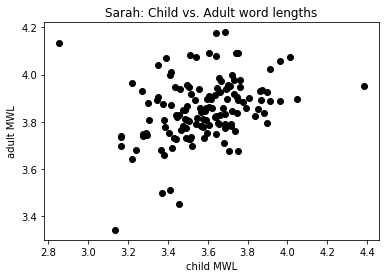

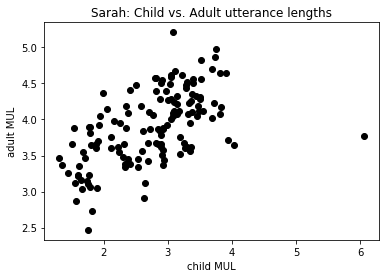

In [7]:
def plot_chi_adt(child_m, adult_m, m_name, title, filename=False):
    """
    Plot child word lengths (x-axis) against adult word 
    lengths (y-axis).
    (see Kunert, Fernandez & Zuidema 2011, Fig. 2)
    """
    plt.figure()
    plt.plot(np.array(child_m)[:,0], np.array(adult_m)[:,0], 'ko')
    plt.xlabel('child ' + m_name)
    plt.ylabel('adult ' + m_name)
    plt.title(title)
    if filename:
        plt.savefig("figures/complexity/" + filename, dpi=300)
        plt.close()
    else:
        plt.show()

mwl_chi = sarah_measures['MWL']['CHI']
mwl_adt = sarah_measures['MWL']['ADT']

mul_chi = sarah_measures['MUL']['CHI']
mul_adt = sarah_measures['MUL']['ADT']

plot_chi_adt(mwl_chi, mwl_adt, 'MWL',
             title="Sarah: Child vs. Adult word lengths")

plot_chi_adt(mul_chi, mul_adt, 'MUL',
             title="Sarah: Child vs. Adult utterance lengths")

#### Over time

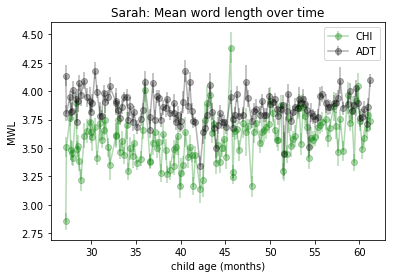

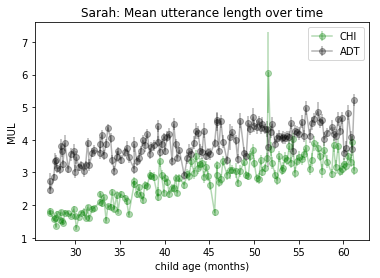

In [8]:
def plot_chi_adt_time(ages, child_m, adult_m, m_name, title, filename=False):
    plt.figure()
    plt.errorbar(ages, np.array(child_m)[:,0], 
                 yerr=np.array(child_m)[:,1],
                 label='CHI', alpha=0.3, fmt='go-')
    plt.errorbar(ages, np.array(adult_m)[:,0], 
                 yerr=np.array(adult_m)[:,1], 
                 label='ADT', alpha=0.3, fmt='ko-')
    plt.legend()
    plt.xlabel('child age (months)')
    plt.ylabel(m_name)
    plt.title(title)
    if filename:
        plt.savefig("figures/complexity/" + filename, dpi=300)
        plt.close()
    else:
        plt.show()
        
plot_chi_adt_time(sarah_ages, mwl_chi, mwl_adt, 'MWL',
                  title="Sarah: Mean word length over time")

plot_chi_adt_time(sarah_ages, mul_chi, mul_adt, 'MUL',
                  title="Sarah: Mean utterance length over time")

### Global recurrence rates over time

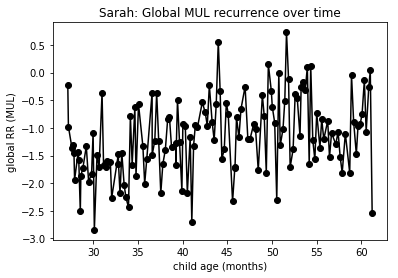

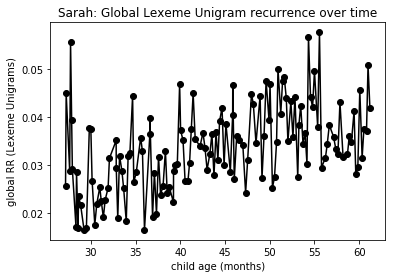

In [9]:
def plot_globRR(ages, globRR, m_name, title, filename=False):
    plt.figure()
    plt.plot(ages, globRR, 'ko-')
    plt.title(title)
    plt.xlabel('child age (months)')
    plt.ylabel('global RR (' + m_name + ')')
    if filename:
        plt.savefig("figures/glob_RR/" + filename, dpi=300)
        plt.close()
    else:
        plt.show()
        
globRR_mul = sarah_measures['MUL']['GlobRR']
globRR_lex = sarah_measures['LexUni']['GlobRR']

plot_globRR(sarah_ages, globRR_mul, 'MUL',
            title="Sarah: Global MUL recurrence over time")

plot_globRR(sarah_ages, globRR_lex, 'Lexeme Unigrams',
           title="Sarah: Global Lexeme Unigram recurrence over time")

### Recurrence plots

(something resembling Fig.1 from Fernandez & Grimm, 2014)

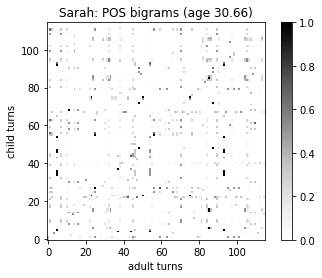

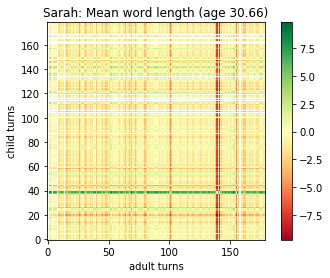

In [10]:
def plot_rec_matrix(rec_mat, cmap, title, filename=False):
    """
    Plot recurrence matrix (like Fernandez & Grimm 2014, Fig.1)
    on alignment measures or on difference in complexity measures.
    """
    plt.figure()
    plt.imshow(rec_mat, cmap=cmap)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.xlabel('adult turns')
    plt.ylabel('child turns')
    plt.title(title)
    if filename:
        plt.savefig("figures/recurrence_plots/" + filename, dpi=300)
        plt.close()
    else:
        plt.show()

age = list(sarah_sent_turn_pairs.keys())[-4]
pos_al = sarah_measures['PosBi']['matrix'][age]
mwl_al = sarah_measures['MWL']['matrix'][age]

plot_rec_matrix(pos_al, cmap='Greys', 
                title="Sarah: POS bigrams (age " + str(age) + ")")

plot_rec_matrix(mwl_al, cmap='RdYlGn',
                title="Sarah: Mean word length (age " + str(age) + ")")

### Local RR for varying d
(something resembling Fig. 2 from Fernandez & Grimm 2014)

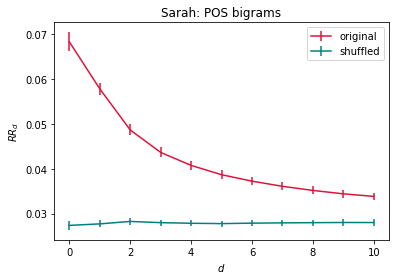

In [11]:
def plot_locRR(locRR, locRR_shf, title, filename=False):
    """
    Plot the local RR (averaged over all dialogues) at different
    levels of d in original vs. shuffled dialogues.
    (see Fernandez & Grimm 2014, Fig. 2)
    """
    plt.figure()
    xs = [int(d) for d in sorted(locRR.keys())]
    y = [np.mean(locRR[d]) for d in sorted(locRR.keys())]
    yerr = [nansem(locRR[d]) for d in sorted(locRR.keys())]
    y_shf = [np.mean(locRR_shf[d]) for d in sorted(locRR_shf.keys())]
    yerr_shf = [nansem(locRR_shf[d]) for d in sorted(locRR_shf.keys())]
    plt.errorbar(xs, y, yerr, color='crimson', label='original')
    plt.errorbar(xs, y_shf, yerr_shf, color='teal', label='shuffled')
    plt.xlabel('$d$')
    plt.ylabel('$RR_d$')
    plt.title(title)
    plt.legend()
    if filename:
        plt.savefig("figures/local_RR/" + filename, dpi=300)
        plt.close()
    else:
        plt.show()

locRR = sarah_measures['PosBi']['LocRR']
locRR_shf = sarah_measures['PosBi']['shLocRR']
    
plot_locRR(locRR, locRR_shf, title="Sarah: POS bigrams")

### Paired t-tests for positive & negative RR_2

Fernandez & Grimm 2014, Table 3

Is recurrence significantly higher when the adult's turn follows the child's?

In [12]:
# Mean word length: no
mwl_RR2pos = sarah_measures['MWL']['RR2pos']
mwl_RR2neg = sarah_measures['MWL']['RR2neg']
ttest_rel(mwl_RR2pos, mwl_RR2neg)

Ttest_relResult(statistic=-0.7267495820162329, pvalue=0.4686103516614166)

In [13]:
# Mean utterance length: no
mul_RR2pos = sarah_measures['MUL']['RR2pos']
mul_RR2neg = sarah_measures['MUL']['RR2neg']
ttest_rel(mul_RR2pos, mul_RR2neg)

Ttest_relResult(statistic=0.1491295573253919, pvalue=0.8816691165858854)

In [14]:
# Lexeme unigrams: yes!
# RR2pos is significantly smaller than RR2neg
# because t < 0; this is a 2-tailed test, for 1-tailed divide p by 2
lexuni_RR2pos = sarah_measures['LexUni']['RR2pos']
lexuni_RR2neg = sarah_measures['LexUni']['RR2neg']
ttest_rel(lexuni_RR2pos, lexuni_RR2neg)

Ttest_relResult(statistic=-23.881675539884725, pvalue=7.290067041154482e-51)

In [15]:
# Lexeme bigrams: yes!
# RR2pos is significantly smaller than RR2neg
# because t < 0; this is a 2-tailed test, for 1-tailed divide p by 2
lexbi_RR2pos = sarah_measures['LexBi']['RR2pos']
lexbi_RR2neg = sarah_measures['LexBi']['RR2neg']
ttest_rel(lexbi_RR2pos, lexbi_RR2neg)

Ttest_relResult(statistic=-17.747828094965453, pvalue=1.9525788099178286e-37)

In [16]:
# POS bigrams: yes!
# RR2pos is significantly smaller than RR2neg
# because t < 0; this is a 2-tailed test, for 1-tailed divide p by 2
posbi_RR2pos = sarah_measures['PosBi']['RR2pos']
posbi_RR2neg = sarah_measures['PosBi']['RR2neg']
ttest_rel(posbi_RR2pos, posbi_RR2neg)

Ttest_relResult(statistic=-17.568316765840326, pvalue=5.1794593519666375e-37)

### Plot all the plots!!!
Save to figures directory

In [17]:
# child_name = 'Adam'
# child_ages = adam_ages
# measures = adam_measures

# # complexity convergence
# plot_chi_adt(measures['MWL']['CHI'], measures['MWL']['ADT'], 
#              'MWL', title=child_name + ": Child vs. Adult word lengths",
#              filename=child_name + "_CHI-ADT_MWL.png")
# plot_chi_adt(measures['MUL']['CHI'], measures['MUL']['ADT'], 
#              'MUL', title=child_name + ": Child vs. Adult utterance lengths",
#              filename=child_name + "_CHI-ADT_MUL.png")
# plot_chi_adt_time(child_ages, measures['MWL']['CHI'], measures['MWL']['ADT'], 
#                   'MWL', title=child_name + ": Mean word length over time",
#                   filename=child_name + "_CHI-ADT_time_MWL.png")
# plot_chi_adt_time(child_ages, measures['MUL']['CHI'], measures['MUL']['ADT'], 
#                   'MUL', title=child_name + ": Mean utterance length over time",
#                   filename=child_name + "_CHI-ADT_time_MUL.png")

# # global recurrence over time
# plot_globRR(child_ages, measures['MWL']['GlobRR'], 'MWL',
#             title=child_name + ": Global MWL recurrence over time",
#             filename=child_name + "_globRR_MWL.png")
# plot_globRR(child_ages, measures['MUL']['GlobRR'], 'MUL',
#             title=child_name + ": Global MUL recurrence over time",
#             filename=child_name + "_globRR_MUL.png")
# plot_globRR(child_ages, measures['LexUni']['GlobRR'], 'Lexeme Unigrams',
#             title=child_name + ": Global Lexeme Unigram recurrence over time",
#             filename=child_name + "_globRR_LexUni.png")
# plot_globRR(child_ages, measures['LexBi']['GlobRR'], 'Lexeme Bigrams',
#             title=child_name + ": Global Lexeme Bigram recurrence over time",
#             filename=child_name + "_globRR_LexBi.png")
# plot_globRR(child_ages, measures['PosBi']['GlobRR'], 'POS Bigrams',
#             title=child_name + ": Global POS Bigram recurrence over time",
#             filename=child_name + "_globRR_PosBi.png")

# # recurrence plots
# for age in child_ages:
#     plot_rec_matrix(measures['MWL']['matrix'][age], cmap='RdYlGn',
#                     title=child_name + ": Mean word length (age " + 
#                     str(round(age,2)) + "mo)",
#                     filename=child_name + "/MWL_" + str(round(age,2)) + ".png")
#     plot_rec_matrix(measures['MUL']['matrix'][age], cmap='RdYlGn',
#                     title=child_name + ": Mean utterance length (age " + 
#                     str(round(age,2)) + "mo)",
#                     filename=child_name + "/MUL_" + str(round(age,2)) + ".png")
    
#     plot_rec_matrix(measures['LexUni']['matrix'][age], cmap='Greys',
#                     title=child_name + ": Lexeme Unigrams (age " + 
#                     str(round(age,2)) + "mo)",
#                     filename=child_name + "/LexUni_" + str(round(age,2)) + ".png")
#     plot_rec_matrix(measures['LexBi']['matrix'][age], cmap='Greys',
#                     title=child_name + ": Lexeme Bigrams (age " + 
#                     str(round(age,2)) + "mo)",
#                     filename=child_name + "/LexBi_" + str(round(age,2)) + ".png")
#     plot_rec_matrix(measures['PosBi']['matrix'][age], cmap='Greys',
#                     title=child_name + ": POS Bigrams (age " + 
#                     str(round(age,2)) + "mo)",
#                     filename=child_name + "/PosBi_" + str(round(age,2)) + ".png")
    
# # local RR for varying d
# plot_locRR(measures['MWL']['LocRR'], measures['MWL']['shLocRR'], 
#            title=child_name + ": Mean word length",
#            filename=child_name + "_locRR_MWL.png")
# plot_locRR(measures['MUL']['LocRR'], measures['MUL']['shLocRR'], 
#            title=child_name + ": Mean utterance length",
#            filename=child_name + "_locRR_MUL.png")
# plot_locRR(measures['LexUni']['LocRR'], measures['LexUni']['shLocRR'], 
#            title=child_name + ": Lexical Unigrams",
#            filename=child_name + "_locRR_LexUni.png")
# plot_locRR(measures['LexBi']['LocRR'], measures['LexBi']['shLocRR'], 
#            title=child_name + ": Lexical Bigrams",
#            filename=child_name + "_locRR_LexBi.png")
# plot_locRR(measures['PosBi']['LocRR'], measures['PosBi']['shLocRR'], 
#            title=child_name + ": POS Bigrams",
#            filename=child_name + "_locRR_PosBi.png")